# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [3]:
!pip install finance-datareader

In [4]:
import FinanceDataReader as fdr

In [5]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [6]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-11-24,76000,76200,74100,74800,15652305,-0.006640
2021-11-25,75100,75100,73600,73700,12559258,-0.014706
2021-11-26,73500,74100,72000,72300,13002242,-0.018996
2021-11-29,71700,73000,71400,72300,16682559,0.000000
2021-11-30,73200,73900,70500,71300,29641025,-0.013831


**미국 주식 데이터**도 가져올 수 있습니다.

In [7]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL')

In [8]:
apple.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2021-11-22,161.02,161.68,165.70,161.00,116200000.0,0.0029
2021-11-23,161.41,161.12,161.80,159.06,95440000.0,0.0024
2021-11-24,161.94,160.75,162.14,159.64,69460000.0,0.0033
2021-11-26,156.81,159.57,160.45,156.36,76950000.0,-0.0317
2021-11-29,160.24,159.37,161.19,158.79,87420000.0,0.0219


다음과 같이 `2017`을 같이 넘겨주면, 해당 시점 이후의 주식 데이터를 가져옵니다.

In [9]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL', '2017')

In [10]:
apple.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2017-01-03,29.04,28.95,29.08,28.69,115130000.0,0.0031
2017-01-04,29.00,28.96,29.13,28.94,84470000.0,-0.0014
2017-01-05,29.15,28.98,29.22,28.95,88770000.0,0.0052
2017-01-06,29.48,29.20,29.54,29.12,127010000.0,0.0113
2017-01-09,29.75,29.49,29.86,29.48,134250000.0,0.0092


**시작**과 **끝** 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.

In [11]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2019-12-30')

In [12]:
ford.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-03-18,1.83,1.83,1.85,1.82,3770000.0,-0.0108
1980-03-19,1.85,1.85,1.86,1.83,1560000.0,0.0109
1980-03-20,1.86,1.86,1.88,1.85,1450000.0,0.0054
1980-03-21,1.78,1.78,1.85,1.76,5020000.0,-0.0430
1980-03-24,1.71,1.71,1.75,1.66,3330000.0,-0.0393


In [13]:
ford.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2019-12-23,9.44,9.50,9.57,9.40,54800000.0,-0.0042
2019-12-24,9.47,9.44,9.49,9.43,11880000.0,0.0032
2019-12-26,9.45,9.47,9.49,9.43,28980000.0,-0.0021
2019-12-27,9.36,9.45,9.46,9.35,28270000.0,-0.0095
2019-12-30,9.25,9.34,9.35,9.23,36090000.0,-0.0118


그 밖에 **금, 은과 같은 현물**, **달러와 같은 화폐** 데이터도 가져올 수 있습니다.

더욱 자세한 내용은 [GitHub 페이지 링크](https://github.com/FinanceData/FinanceDataReader)를 참고해 보시기 바랍니다.

In [ ]:
## 주가데이터 가져오기

지난 주식 예측 튜토리얼에서는 **삼성전자** 주가데이터로 실습을 해봤으니, 

이번에는 글로벌 증시의 대장주인 **Apple**사의 주가데이터를 가져와서 예측해 보도록 하겠습니다.

In [14]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [15]:
stock = fdr.DataReader(STOCK_CODE)

In [16]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1997-10-30,750,773,714,715,373530,NaN
1997-10-31,714,714,657,677,425381,-0.053147
1997-11-01,679,730,677,731,323800,0.079764
1997-11-03,782,788,736,788,863870,0.077975
1997-11-04,795,850,795,851,478162,0.079949


In [17]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-11-24,76000,76200,74100,74800,15652305,-0.006640
2021-11-25,75100,75100,73600,73700,12559258,-0.014706
2021-11-26,73500,74100,72000,72300,13002242,-0.018996
2021-11-29,71700,73000,71400,72300,16682559,0.000000
2021-11-30,73200,73900,70500,71300,29641025,-0.013831


In [18]:
stock.index

DatetimeIndex(['1997-10-30', '1997-10-31', '1997-11-01', '1997-11-03',
               '1997-11-04', '1997-11-05', '1997-11-06', '1997-11-07',
               '1997-11-08', '1997-11-10',
               ...
               '2021-11-17', '2021-11-18', '2021-11-19', '2021-11-22',
               '2021-11-23', '2021-11-24', '2021-11-25', '2021-11-26',
               '2021-11-29', '2021-11-30'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [19]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [20]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1997-10-30,750,773,714,715,373530,NaN,1997,10,30
1997-10-31,714,714,657,677,425381,-0.053147,1997,10,31
1997-11-01,679,730,677,731,323800,0.079764,1997,11,1
1997-11-03,782,788,736,788,863870,0.077975,1997,11,3
1997-11-04,795,850,795,851,478162,0.079949,1997,11,4


## 시각화

Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


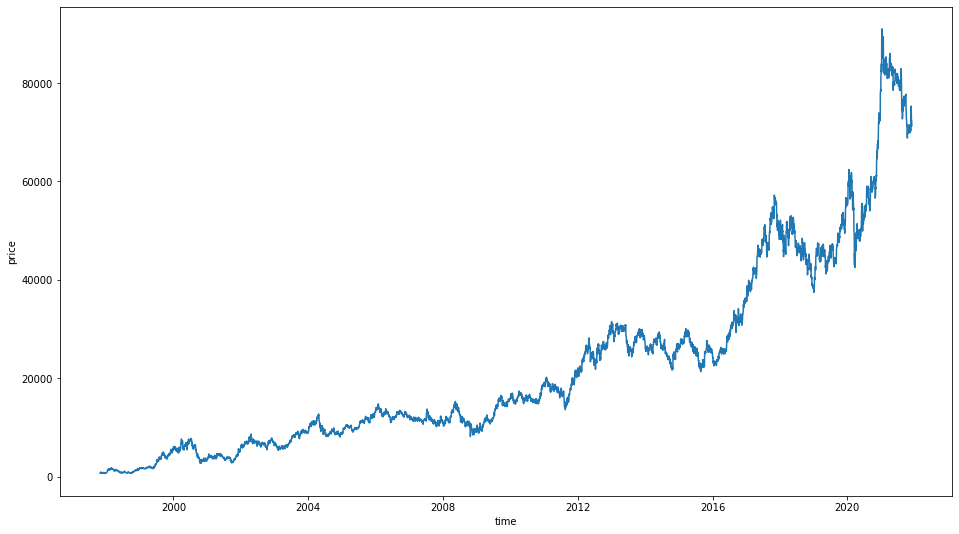

In [21]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


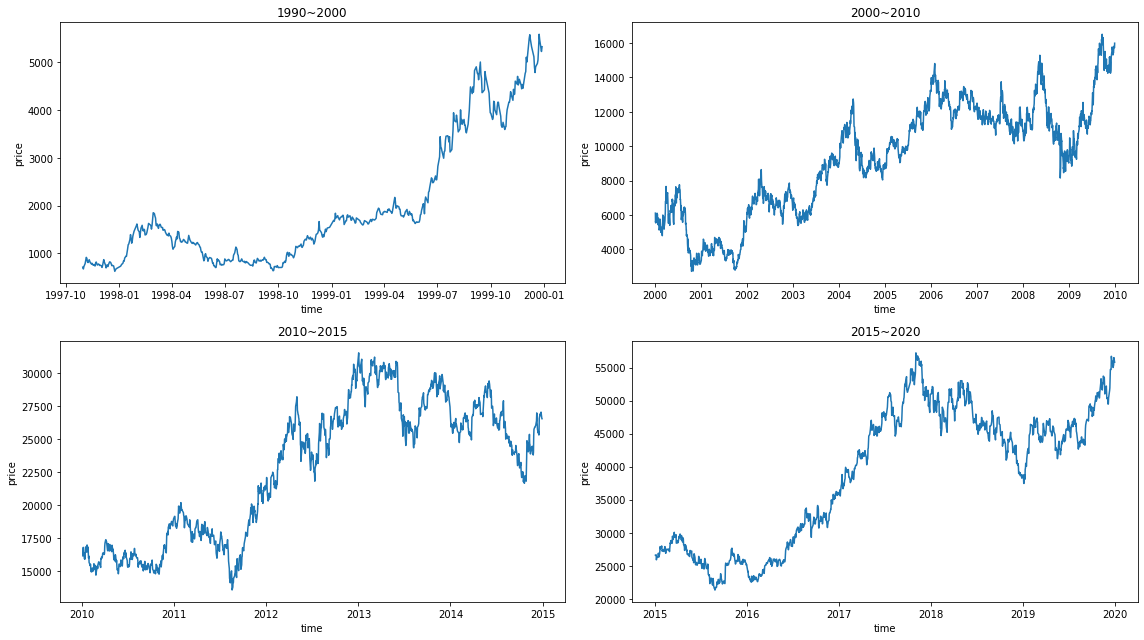

In [22]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[8.30564784e-03, 7.98553719e-03, 7.97765363e-03, 9.73742158e-04,
        4.13626191e-03],
       [7.90697674e-03, 7.37603306e-03, 7.34078212e-03, 5.53262589e-04,
        4.71043083e-03],
       [7.51937984e-03, 7.54132231e-03, 7.56424581e-03, 1.15078619e-03,
        3.58557975e-03],
       ...,
       [8.13953488e-01, 7.65495868e-01, 8.04469274e-01, 7.93079792e-01,
        1.43979542e-01],
       [7.94019934e-01, 7.54132231e-01, 7.97765363e-01, 7.93079792e-01,
        1.84733310e-01],
       [8.10631229e-01, 7.63429752e-01, 7.87709497e-01, 7.82014540e-01,
        3.28228101e-01]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [24]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [27]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [28]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [59]:
x_train

,Open,High,Low,Volume
0,0.008306,0.007986,0.007978,0.004136
1,0.007907,0.007376,0.007341,0.004710
2,0.007519,0.007541,0.007564,0.003586
3,0.008660,0.008140,0.008223,0.009566
4,0.008804,0.008781,0.008883,0.005295
...,...,...,...,...
4795,0.404208,0.377273,0.403352,0.001765
4796,0.399336,0.372521,0.397095,0.002429
4797,0.400664,0.376446,0.402682,0.001967
4798,0.405316,0.387397,0.408492,0.002922


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [30]:
import tensorflow as tf

In [31]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [54]:
WINDOW_SIZE=2
BATCH_SIZE=3

In [55]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [56]:
aa =  list(train_data)
aa[0]

(<tf.Tensor: shape=(3, 2, 1), dtype=float64, numpy=
 array([[[0.00150487],
         [0.00139422]],
 
        [[0.03499939],
         [0.03688048]],
 
        [[0.03621657],
         [0.03389287]]])>, <tf.Tensor: shape=(3, 1), dtype=float64, numpy=
 array([[0.00141635],
        [0.03632722],
        [0.03356091]])>)

In [57]:
y_train

0       0.000974
1       0.000553
2       0.001151
3       0.001782
4       0.002479
          ...   
4795    0.393182
4796    0.386542
4797    0.393624
4798    0.404911
4799    0.405132
Name: Close, Length: 4800, dtype: float64

In [34]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [36]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [37]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [45]:
train_data

<PrefetchDataset shapes: ((None, None, 1), (None, 1)), types: (tf.float64, tf.float64)>


In [38]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=10, 
                    callbacks=[checkpoint, earlystopping])
model.fit()

Epoch 1/10
    148/Unknown - 13s 10ms/step - loss: 1.2283e-04 - mse: 2.4566e-04
Epoch 00001: val_loss improved from inf to 0.00362, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 14s 19ms/step - loss: 1.2217e-04 - mse: 2.4434e-04 - val_loss: 0.0036 - val_mse: 0.0072
Epoch 2/10
145/150 [============================>.] - ETA: 0s - loss: 2.8727e-05 - mse: 5.7454e-05
Epoch 00002: val_loss improved from 0.00362 to 0.00316, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 2s 12ms/step - loss: 2.9604e-05 - mse: 5.9209e-05 - val_loss: 0.0032 - val_mse: 0.0063
Epoch 3/10
147/150 [============================>.] - ETA: 0s - loss: 2.8883e-05 - mse: 5.7766e-05
Epoch 00003: val_loss improved from 0.00316 to 0.00237, saving model to tmp/ckeckpointer.ckpt
150/150 [==============================] - 2s 14ms/step - loss: 2.9224e-05 - mse: 5.8449e-05 - val_loss: 0.0024 - val_mse: 0.0047
Epoch 4/10
144/150 [===========================>..] -

저장한 ModelCheckpoint 를 로드합니다.

In [39]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [40]:
pred = model.predict(test_data)

In [41]:
pred.shape

(1180, 1)

## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

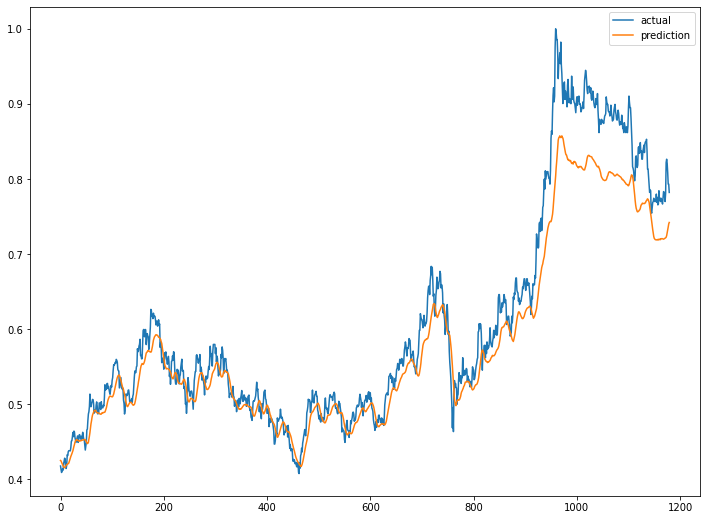

In [42]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [1]:
a = {"nso" : 'so:r,p:from20200101to20211130,a:all'}

In [2]:
a['nso']

'so:r,p:from20200101to20211130,a:all'